<a href="https://colab.research.google.com/github/PRASANNA-416/IT414-Mini-Project/blob/main/Res50%2BMultipathunet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import os
import tensorflow as tf

input_dir = "/content/gdrive/MyDrive/ML/kvasir-seg/Kvasir-SEG/images"
target_dir = "/content/gdrive/MyDrive/ML/kvasir-seg/Kvasir-SEG/masks"

num_input_images = len(os.listdir(input_dir))
num_target_images = len(os.listdir(target_dir))

print("Number of input images:", num_input_images)
print("Number of target images:", num_target_images)

Number of input images: 1000
Number of target images: 1000


In [3]:

import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, add
from keras.models import Model, model_from_json
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras import backend as K 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.utils import Sequence
import os
import numpy as np
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

class CustomDataGenerator(Sequence):
    def __init__(self, input_dir, mask_dir, batch_size, target_size=(224, 224), shuffle=True):
        self.input_dir = input_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle

        # Get list of image and mask file names
        self.filenames = os.listdir(self.input_dir)

        # Get number of batches per epoch
        self.steps_per_epoch = len(self.filenames) // self.batch_size

        # Shuffle filenames
        if self.shuffle:
            np.random.shuffle(self.filenames)

        # Set up data augmentation generator
        self.datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )

    def __len__(self):
        return self.steps_per_epoch

    def __getitem__(self, index):
        # Get batch indexes
        batch_filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]

        # Initialize batch arrays
        batch_input = np.zeros((self.batch_size, *self.target_size, 3))
        batch_mask = np.zeros((self.batch_size, *self.target_size, 1))

        # Load and augment batch images and masks
        for i, filename in enumerate(batch_filenames):
            # Load input image
            input_path = os.path.join(self.input_dir, filename)
            input_img = load_img(input_path, target_size=self.target_size)
            input_array = img_to_array(input_img)

            # Load target mask
            mask_path = os.path.join(self.mask_dir, filename)
            mask_img = load_img(mask_path, target_size=self.target_size, color_mode='grayscale')
            mask_array = img_to_array(mask_img)

            # Apply data augmentation to input and mask images
            input_array, mask_array = self.apply_data_augmentation(input_array, mask_array)

            # Normalize input image and mask
            input_array = input_array / 255.0
            mask_array = mask_array / 255.0

            # Add to batch arrays
            batch_input[i] = input_array
            batch_mask[i] = mask_array

        return batch_input, batch_mask

    def apply_data_augmentation(self, input_array, mask_array):
        # Combine input and mask arrays for data augmentation
        combined = np.concatenate([input_array, mask_array], axis=2)

        # Apply data augmentation
        augmented = self.datagen.random_transform(combined)

        # Split augmented array back into input and mask arrays
        aug_input = augmented[..., :3]
        aug_mask = augmented[..., 3:]

        return aug_input, aug_mask


In [4]:
image_dir = '/content/gdrive/MyDrive/ML/kvasir-seg/Kvasir-SEG/images'
mask_dir = '/content/gdrive/MyDrive/ML/kvasir-seg/Kvasir-SEG/masks'

# Define the batch size and target image size
batch_size = 10
target_size = (224, 224)

# Create the custom data generator
data_generator = CustomDataGenerator(image_dir, mask_dir, batch_size, target_size)

In [5]:

from keras.metrics import MeanIoU

def dice_coefficient(y_true, y_pred, smooth=1.0):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true), axis=-1) + K.sum(K.square(y_pred), axis=-1) + smooth)


In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Concatenate, Conv2DTranspose, BatchNormalization, Activation, UpSampling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50

def MultiPathUnet(input_shape, num_classes):
    # Encoder
    resnet = ResNet50(include_top=False, input_shape=input_shape)
    resnet_out = resnet.output

    # Decoder
    # Block 1
    up1 = UpSampling2D(size=(2, 2))(resnet_out)
    conv1 = Conv2D(512, (3, 3), padding='same')(up1)
    bn1 = BatchNormalization()(conv1)
    act1 = Activation('relu')(bn1)
    conv1 = Conv2D(512, (3, 3), padding='same')(act1)
    bn1 = BatchNormalization()(conv1)
    act1 = Activation('relu')(bn1)

    # Block 2
    up2 = UpSampling2D(size=(2, 2))(act1)
    conv2 = Conv2D(256, (3, 3), padding='same')(up2)
    bn2 = BatchNormalization()(conv2)
    act2 = Activation('relu')(bn2)
    conv2 = Conv2D(256, (3, 3), padding='same')(act2)
    bn2 = BatchNormalization()(conv2)
    act2 = Activation('relu')(bn2)

    # Block 3
    up3 = UpSampling2D(size=(2, 2))(act2)
    conv3 = Conv2D(128, (3, 3), padding='same')(up3)
    bn3 = BatchNormalization()(conv3)
    act3 = Activation('relu')(bn3)
    conv3 = Conv2D(128, (3, 3), padding='same')(act3)
    bn3 = BatchNormalization()(conv3)
    act3 = Activation('relu')(bn3)

    # Block 4
    up4 = UpSampling2D(size=(2, 2))(act3)
    conv4 = Conv2D(64, (3, 3), padding='same')(up4)
    bn4 = BatchNormalization()(conv4)
    act4 = Activation('relu')(bn4)
    conv4 = Conv2D(64, (3, 3), padding='same')(act4)
    bn4 = BatchNormalization()(conv4)
    act4 = Activation('relu')(bn4)

    # Output
    output = Conv2D(num_classes, (1, 1), activation='sigmoid')(act4)

    # Upsample output to original input size
    output = UpSampling2D(size=(2, 2))(output)


    model = Model(inputs=resnet.input, outputs=output)

    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = MultiPathUnet((224, 224, 3),1)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [7]:
from keras.optimizers import Adam
from keras.metrics import MeanIoU
import tensorflow as tf
import keras.backend as K

def dice_coefficient(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true), axis=-1) + K.sum(K.square(y_pred), axis=-1) + smooth)

# Register the function using custom_object_scope
from keras.utils import custom_object_scope
with custom_object_scope({'dice_coefficient': dice_coefficient}):
    # build and compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', dice_coefficient])

In [8]:
model.fit(data_generator, epochs=10,steps_per_epoch = 10)

Epoch 1/10
10/10 [==============================] - 237s 21s/step - loss: 0.4652 - accuracy: 0.8156 - dice_coefficient: 0.9062
Epoch 2/10
10/10 [==============================] - 207s 20s/step - loss: 0.3274 - accuracy: 0.8706 - dice_coefficient: 0.9425
Epoch 3/10
10/10 [==============================] - 204s 20s/step - loss: 0.3051 - accuracy: 0.8637 - dice_coefficient: 0.9463
Epoch 4/10
10/10 [==============================] - 205s 20s/step - loss: 0.2795 - accuracy: 0.8726 - dice_coefficient: 0.9501
Epoch 5/10
10/10 [==============================] - 201s 20s/step - loss: 0.2839 - accuracy: 0.8743 - dice_coefficient: 0.9526
Epoch 6/10
10/10 [==============================] - 204s 20s/step - loss: 0.2819 - accuracy: 0.8801 - dice_coefficient: 0.9490
Epoch 7/10
10/10 [==============================] - 201s 20s/step - loss: 0.2574 - accuracy: 0.8938 - dice_coefficient: 0.9591
Epoch 8/10
10/10 [==============================] - 200s 20s/step - loss: 0.2188 - accuracy: 0.9032 - dice_coef

In [18]:
model.save_weights('Res50MultipathUNET.h5')

TESTING

In [28]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array


# Define the testing directory containing images and masks
testing_dir = '/content/gdrive/MyDrive/ML/kvasir-sessile/sessile-main-Kvasir-SEG'
images_dir = '/content/gdrive/MyDrive/ML/kvasir-sessile/sessile-main-Kvasir-SEG/images'
masks_dir = '/content/gdrive/MyDrive/ML/kvasir-sessile/sessile-main-Kvasir-SEG/masks'

# Define the target image size
target_size = (224, 224)

# Get the list of image file names
image_files = os.listdir(images_dir)

# Sort the list of file names
image_files.sort()

# Create empty lists for images and masks
input_images = []
actual_masks = []

# Loop over the image file names
for i in range(len(image_files)):
    # Load the input image
    image_path = os.path.join(images_dir, image_files[i])
    input_image = load_img(image_path, target_size=target_size)
    input_image_array = img_to_array(input_image) / 255.0
    input_images.append(input_image_array)

    # Load the actual mask
    mask_file = image_files[i].split('.')[0] + '.jpg'
    mask_path = os.path.join(masks_dir, mask_file)
    actual_mask = load_img(mask_path, color_mode='grayscale', target_size=target_size)
    actual_mask_array = img_to_array(actual_mask) / 255.0
    actual_masks.append(actual_mask_array)

# Convert the lists of images and masks to arrays
input_images = np.array(input_images)
actual_masks = np.array(actual_masks)


# Convert lists to numpy arrays
x = np.array(input_images)
y = np.array(actual_masks)

# Normalize input images
x = x / 255.0

# Change label 2 to 1
y[y == 2] = 1

print("Input images shape:", x.shape)
print("Target images shape:", y.shape)

Input images shape: (196, 224, 224, 3)
Target images shape: (196, 224, 224, 1)


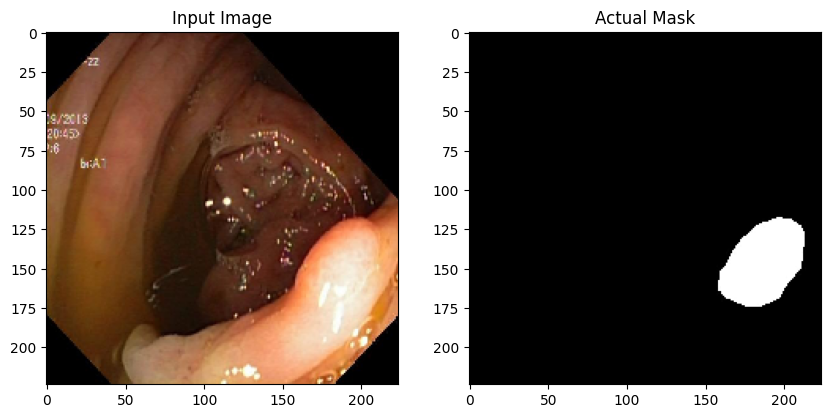

In [34]:
import matplotlib.pyplot as plt

# Plot the first image and its mask
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].imshow(input_images[1])
axes[0].set_title('Input Image')

axes[1].imshow(actual_masks[1], cmap='gray')
axes[1].set_title('Actual Mask')

plt.show()


In [25]:

# Evaluate the model on the testing data
with custom_object_scope({'dice_coefficient': dice_coefficient}):
    loss, accuracy, dice = model.evaluate(x, y, verbose=0)

print(f'Testing loss: {loss:.4f}, Testing accuracy: {accuracy:.4f}, Testing dice: {dice:.4f}')


Testing loss: 0.2975, Testing accuracy: 0.9196, Testing dice: 0.9476


1/1 [==============================] - 0s 435ms/step


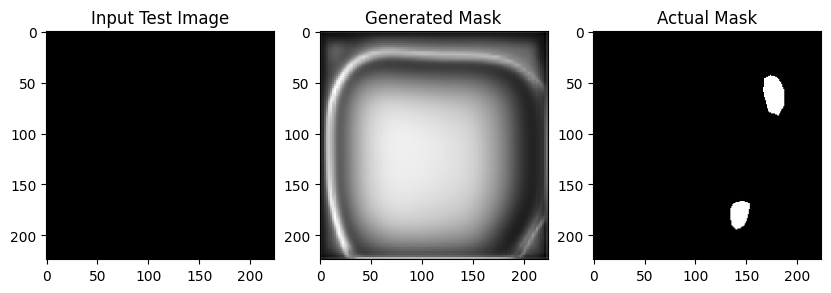

In [36]:
import matplotlib.pyplot as plt

# Define the index of the test image to plot
idx = 23

# Predict the mask for the test image using the model
test_image = input_images[idx]
predicted_mask = model.predict(test_image[np.newaxis, ...])[0]

# Get the actual mask for the test image
actual_mask = actual_masks[idx]

# Rescale the input test image and masks for plotting
input_image = input_images[idx] / 255.0
predicted_mask = np.squeeze(predicted_mask)
actual_mask = np.squeeze(actual_mask)

# Plot the input test image and masks
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
axs[0].imshow(input_image)
axs[0].set_title('Input Test Image')
axs[1].imshow(predicted_mask, cmap='gray')
axs[1].set_title('Generated Mask')
axs[2].imshow(actual_mask, cmap='gray')
axs[2].set_title('Actual Mask')
plt.show()

